In [2]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.io as sio
import time
import yaml
import random
import json
import shutil

from skimage import io, color
from fitter import Fitter
from tqdm import tqdm
from randstainna import RandStainNA
from sklearn.model_selection import train_test_split

### 1. Extract Binary Masks

##### 1-1. Lizard

In [2]:
# extract binary mask image files from .mat files
def make_binary_mask(matPath):
    mask = sio.loadmat(matPath)

    inst_map = mask['inst_map']
    nuclear_map = inst_map + 0
    nuclear_map[nuclear_map != 0] = 1

    return nuclear_map

def make_binary_masks(matDir, binDir):
    if not os.path.exists(binDir):
        os.makedirs(binDir)

    matFiles = glob.glob(matDir + '/*.mat')
    for matFile in tqdm(matFiles):
        mask = make_binary_mask(matFile)
        mask = mask.astype(np.uint8)
        mask = mask * 255
        mask = np.stack((mask,)*3, axis=-1)
        mask = mask.astype(np.uint8)
        maskName = os.path.basename(matFile).replace('.mat', '.png')
        maskPath = os.path.join(binDir, maskName)
        io.imsave(maskPath, mask)
        
matDir = 'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\lizard_labels\Lizard_Labels\Labels'
binDir = 'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_labeled'
if not os.path.exists(binDir):
    os.makedirs(binDir)

make_binary_masks(matDir, binDir)

 92%|█████████▏| 218/238 [00:18<00:00, 35.67it/s]C:\Users\hjkwak\AppData\Local\Temp\ipykernel_68288\3021427845.py:24: UserWarning: D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_labeled\pannuke_20.png is a low contrast image
  io.imsave(maskPath, mask)
100%|██████████| 238/238 [00:19<00:00, 12.25it/s]


##### 1-2. Other Datasets

### 2. Random Stain Normalization & Augmentation

##### 2-1. make .yaml

In [3]:
### Inputs ###
dataset_dirs = []

lizard_dir = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/Data/Lizard_original"
dataset_dirs.append(lizard_dir)

save_dir ="D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/Data/NA_statistics"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
dataset_name = "random_images"
methods = 'Reinhard' 
color_space = 'LAB' #LAB, HED or HSV
randomize = True #Randomize the image style class 
n = 0

### Get average and standard deviation from an image, for each channel (L, A, B)
def getavgstd(image):
    avg = []
    std = []
    image_avg_l = np.mean(image[:, :, 0])
    image_std_l = np.std(image[:, :, 0])
    image_avg_a = np.mean(image[:, :, 1])
    image_std_a = np.std(image[:, :, 1])
    image_avg_b = np.mean(image[:, :, 2])
    image_std_b = np.std(image[:, :, 2])
    avg.append(image_avg_l)
    avg.append(image_avg_a)
    avg.append(image_avg_b)
    std.append(image_std_l)
    std.append(image_std_a)
    std.append(image_std_b)
    return (avg, std)
   

labL_avg_List = []
labA_avg_List = []
labB_avg_List = []
labL_std_List = []
labA_std_List = []
labB_std_List = []

t1 = time.time()
i = 0


''' if dataset has multiple classes '''
for dataset_dir in tqdm(dataset_dirs):

    dataset_dir_list = os.listdir(dataset_dir)
    if randomize == True:
        random.shuffle(dataset_dir_list)

    for image in dataset_dir_list:
        if n == 0:  # n=0: all images each class
            pass
        elif i < n:
            i += 1
        else:
            i = 0
            break
        dir_img = os.path.join(dataset_dir, image)
        img = cv2.imread(dir_img)
        try:  # debug
            if color_space == "LAB":
                img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            elif color_space == "HED":
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = color.rgb2hed(img)
            elif color_space == "HSV":
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            else:
                print("wrong color space: {}!!".format(color_space))
            img_avg, img_std = getavgstd(img)
        except:
            print(dir_img)
            continue
        labL_avg_List.append(img_avg[0])
        labA_avg_List.append(img_avg[1])
        labB_avg_List.append(img_avg[2])
        labL_std_List.append(img_std[0])
        labA_std_List.append(img_std[1])
        labB_std_List.append(img_std[2])
        
t2 = time.time()
print(t2 - t1)
l_avg_mean = np.mean(labL_avg_List).item()
l_avg_std = np.std(labL_avg_List).item()
l_std_mean = np.mean(labL_std_List).item()
l_std_std = np.std(labL_std_List).item()
a_avg_mean = np.mean(labA_avg_List).item()
a_avg_std = np.std(labA_avg_List).item()
a_std_mean = np.mean(labA_std_List).item()
a_std_std = np.std(labA_std_List).item()
b_avg_mean = np.mean(labB_avg_List).item()
b_avg_std = np.std(labB_avg_List).item()
b_std_mean = np.mean(labB_std_List).item()
b_std_std = np.std(labB_std_List).item()

std_avg_list = [
    labL_avg_List,
    labL_std_List,
    labA_avg_List,
    labA_std_List,
    labB_avg_List,
    labB_std_List,
]
distribution = []
for std_avg in tqdm(std_avg_list):
    f = Fitter(std_avg, distributions=["norm", "laplace"])
    f.fit()
    distribution.append(list(f.get_best(method="sumsquare_error").keys())[0])

yaml_dict_lab = {
    "random": randomize,
    "n_each_class": n,
    "color_space": color_space,
    "methods": methods,
    "{}".format(color_space[0]): {  # lab-L/hed-H
        "avg": {
            "mean": round(l_avg_mean, 3),
            "std": round(l_avg_std, 3),
            "distribution": distribution[0],
        },
        "std": {
            "mean": round(l_std_mean, 3),
            "std": round(l_std_std, 3),
            "distribution": distribution[1],
        },
    },
    "{}".format(color_space[1]): {  # lab-A/hed-E
        "avg": {
            "mean": round(a_avg_mean, 3),
            "std": round(a_avg_std, 3),
            "distribution": distribution[2],
        },
        "std": {
            "mean": round(a_std_mean, 3),
            "std": round(a_std_std, 3),
            "distribution": distribution[3],
        },
    },
    "{}".format(color_space[2]): {  # lab-B/hed-D
        "avg": {
            "mean": round(b_avg_mean, 3),
            "std": round(b_avg_std, 3),
            "distribution": distribution[4],
        },
        "std": {
            "mean": round(b_std_mean, 3),
            "std": round(b_std_std, 3),
            "distribution": distribution[5],
        },
    },
}
yaml_save_path = "{}/{}.yaml".format(
    save_dir,
    dataset_name
    if dataset_name != ""
    else "dataset_{}_random{}_n{}".format(color_space, randomize, n),
)
with open(yaml_save_path, "w") as f:
    yaml.dump(yaml_dict_lab, f)
    print("The dataset lab statistics has been saved in {}".format(yaml_save_path))


100%|██████████| 1/1 [00:07<00:00,  7.71s/it]


7.710504055023193


  0%|          | 0/6 [00:00<?, ?it/s]2024-05-10 18:01:44.553 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.002232)
2024-05-10 18:01:44.554 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace distribution with error=0.002396)
2024-05-10 18:01:44.585 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.012889)
2024-05-10 18:01:44.588 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace distribution with error=0.013534)
2024-05-10 18:01:44.616 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.020031)
2024-05-10 18:01:44.619 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace distribution with error=0.021782)
2024-05-10 18:01:44.648 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace distribution with error=0.124256)
2024-05-10 18:01:44.649 | INFO     | fitter.fitter:_fit

The dataset lab statistics has been saved in D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/Data/NA_statistics/random_images.yaml


##### 2-2. Normalization & Augmentation

In [4]:
# Setting: is_train = False
randstainna = RandStainNA(
    yaml_file = r"D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\NA_statistics\random_images.yaml",
    std_hyper = 0.0,
    distribution = 'normal',
    probability = 1.0,
    is_train = False
)

dir_path = 'D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/Data/Lizard_original'
img_list = os.listdir(dir_path)


save_dir_path = 'D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/Data/Lizard_original_NA'
if not os.path.exists(save_dir_path):
    os.mkdir(save_dir_path)

''' if dataset has multiple classes '''
for img_path in tqdm(img_list):
    img = randstainna(cv2.imread(dir_path + '/' + img_path))
    save_img_path = save_dir_path + '/{}'.format(img_path.split('/')[-1])
    cv2.imwrite(save_img_path,img)

100%|██████████| 238/238 [00:25<00:00,  9.39it/s]


### 3. fit images into input size

In [5]:
# If image is smaller than input size, fill zeros around the image
def zero_padding(img, patchSize):

    h, w = img.shape[:2]
    
    if h < patchSize:    
        top_pad = (patchSize-h) // 2
        bottom_pad = patchSize - h - top_pad
        img = np.pad(img, ((top_pad, bottom_pad), (0, 0), (0, 0)), mode='constant', constant_values=0)        

    if w < patchSize:
        left_pad = (patchSize-w) // 2
        right_pad = patchSize - w - left_pad
        img = np.pad(img, ((0, 0), (left_pad, right_pad), (0, 0)), mode='constant', constant_values=0)

    return img

In [6]:
# If image is larger than input size, cut the image into 512x512 patches
# If the patch size is smaller than the image size, use zero_padding to fill zeros.
def img_to_patches(img, patchSize):
    patches = []
    h, w = img.shape[:2]
    for i in range(0, h, patchSize):
        for j in range(0, w, patchSize):            
            if i + patchSize > h or j + patchSize > w:
                patch = zero_padding(img[i:i+patchSize, j:j+patchSize], patchSize)
            else:
                patch = img[i:i+patchSize, j:j+patchSize]
            patches.append(patch)
    return patches

In [4]:
def get_1_patch(img, patchSize):
    zero_padded_img = zero_padding(img, patchSize)
    h, w = zero_padded_img.shape[:2]
    center_h, center_w = h//2, w//2
    half_size = patchSize // 2
    return zero_padded_img[center_h-half_size:center_h-half_size+patchSize, center_w-half_size:center_w-half_size+patchSize]

In [28]:
''' Test get_1_patch function '''
# patchSize = 3
# img = np.zeros((1, 5, 3), dtype=np.uint8)
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         for k in range(img.shape[2]):
#             img[i, j, k] = i*6 + j + 10
# print(*img[:,:,0], sep='\n')
# print()

# img = get_1_patch(img, patchSize)

# print(*img[:,:,0], sep='\n')

# img = cv2.imread(r'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_original\crag_17.png')
# print(img.shape)

# img = get_1_patch(img, 512)
# print(img.shape)

# # Save the image patches
# cv2.imwrite(r'consep_1_patch.png', img)

# img = r'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_original\crag_17.png'
# print(os.path.basename(img))

crag_17.png


In [7]:
# apply to all images

def fit_img_size(imgDir, patchSize, saveDir):
    if not os.path.exists(saveDir):
        os.makedirs(saveDir)

    imgFiles = glob.glob(imgDir + '/*.png')
    imgFiles.extend(glob.glob(imgDir + '/*.jpg'))
    
    for imgFile in tqdm(imgFiles):
        img = io.imread(imgFile)
        patches = img_to_patches(img, patchSize)
        for i, patch in enumerate(patches):
            # if file is .jpg, save as .jpg
            if imgFile.endswith('.jpg'):
                patchName = os.path.basename(imgFile).replace('.jpg', '_') + str(i) + '.jpg'
            else:
                patchName = os.path.basename(imgFile).replace('.png', '_') + str(i) + '.png'
            patchPath = os.path.join(saveDir, patchName)
            io.imsave(patchPath, patch)

In [8]:
patchSize = 512

imgDir = 'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_original_NA'
saveimgDir = 'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_original_NA_patches'
if not os.path.exists(saveimgDir):
    os.makedirs(saveimgDir)

maskDir = 'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_labeled'
savemaskDir = 'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_labeled_patches'
if not os.path.exists(savemaskDir):
    os.makedirs(savemaskDir)

overlayDir = 'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\overlay\Overlay'
saveOverlayDir = 'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\overlay\Overlay_patches'
if not os.path.exists(saveOverlayDir):
    os.makedirs(saveOverlayDir)

fit_img_size(imgDir, patchSize, saveimgDir)
fit_img_size(maskDir, patchSize, savemaskDir)
fit_img_size(overlayDir, patchSize, saveOverlayDir)

 14%|█▍        | 33/238 [00:08<01:27,  2.34it/s]C:\Users\hjkwak\AppData\Local\Temp\ipykernel_68288\3714954126.py:20: UserWarning: D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_original_NA_patches\crag_25_4.png is a low contrast image
  io.imsave(patchPath, patch)
 18%|█▊        | 43/238 [00:12<01:21,  2.39it/s]C:\Users\hjkwak\AppData\Local\Temp\ipykernel_68288\3714954126.py:20: UserWarning: D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_original_NA_patches\crag_34_3.png is a low contrast image
  io.imsave(patchPath, patch)
 32%|███▏      | 75/238 [00:25<01:06,  2.45it/s]C:\Users\hjkwak\AppData\Local\Temp\ipykernel_68288\3714954126.py:20: UserWarning: D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data\Lizard_original_NA_patches\crag_63_0.png is a low contrast image
  io.imsave(patchPath, patch)
 35%|███▌      | 84/238 [00:30<01:22,  1.88it/s]C:\Users\hjkwak\AppData\Local\Temp\ipykernel_68288\3714954126.py:20: UserWarning: D:\hjkwak\PROJ_Nuclei_Segmenta

### 4. Convert label masks to COCO Json

In [9]:
def get_image_mask_pairs(data_dir):
    image_paths = []
    mask_paths = []
    
    for root, _, files in tqdm(os.walk(data_dir), desc='get_image_mask_pairs:'):
        if 'Lizard_original_NA_patches' in root:
            for file in files:
                if file.endswith('.png'):
                    image_paths.append(os.path.join(root, file))
                    mask_paths.append(os.path.join(root.replace('Lizard_original_NA_patches', 'Lizard_labeled_patches'), file))
    
    return image_paths, mask_paths

In [7]:
def mask_to_polygons(mask, epsilon=1.0):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
            poly = contour.reshape(-1).tolist()
            if len(poly) > 4:  # Ensure valid polygon
                polygons.append(poly)
    return polygons

In [15]:
def process_data(image_paths, mask_paths, output_dir):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0
        
    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), desc='process_data:'):
        image_id += 1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        
        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))
        
        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })
        
        unique_values = np.unique(mask)
        
        
        for value in unique_values:
            if value == 0:  # Ignore background
                continue
            
            
            object_mask = (mask == value).astype(np.uint8) * 255
                        
            polygons = mask_to_polygons(object_mask)
            
            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": 1,  # Only one category: Nuclei
                    "segmentation": [poly],
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    "iscrowd": 0
                })
    
    coco_output = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": 1, "name": "Nuclei"}]
    }
    
    with open(os.path.join(output_dir, 'coco_annotations.json'), 'w') as f:
        json.dump(coco_output, f)

In [12]:
data_dir = r'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\Data'
output_dir = r'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\COCO_Dataset'
os.makedirs(output_dir, exist_ok=True)


train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

image_paths, mask_paths = get_image_mask_pairs(data_dir)

# Split data into train and val
# train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Split data into train, val, and test
train_img_paths, rest_img_paths, train_mask_paths, rest_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
val_img_paths, test_img_paths, val_mask_paths, test_mask_paths = train_test_split(rest_img_paths, rest_mask_paths, test_size=0.33, random_state=42)



# Process train and val data
process_data(train_img_paths, train_mask_paths, train_dir)
process_data(val_img_paths, val_mask_paths, val_dir)
process_data(test_img_paths, test_mask_paths, test_dir)


get_image_mask_pairs:: 7it [00:00, 777.44it/s]
process_data:: 976it [00:22, 43.51it/s]
process_data:: 280it [00:06, 44.64it/s]
process_data:: 139it [00:03, 44.60it/s]


##### Check if COCO Json is fine

['D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train\\dpath_27_9.png', 'D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train\\crag_26_4.png', 'D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train\\crag_59_5.png', 'D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train\\glas_57_0.png']


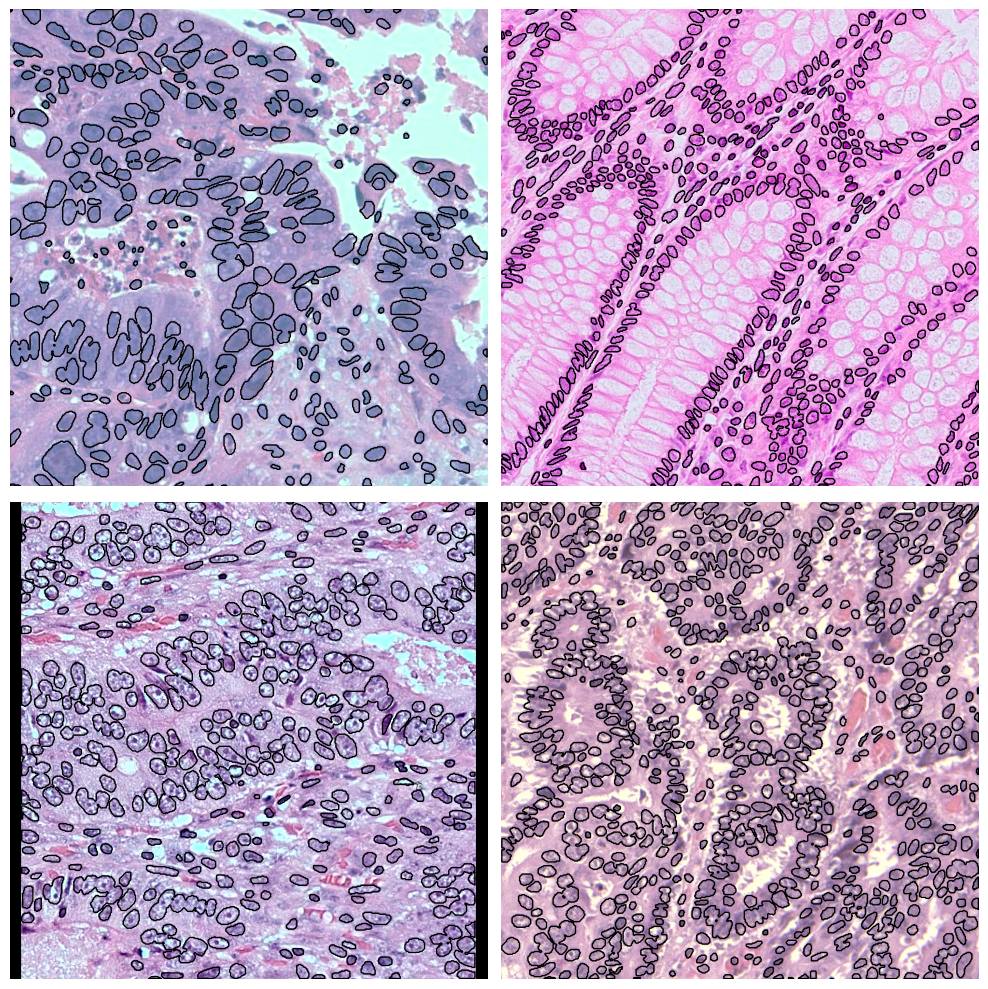

In [12]:
def display_images_with_coco_annotations(image_paths, annotations, display_type='both'):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        
        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
        
        # Generate random colors for each annotation
        # colors = [tuple(np.random.rand(3)) for _ in img_annotations]
        colors = [(0, 0, 0)] * len(img_annotations)


        for ann, color in zip(img_annotations, colors):
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                                         linewidth=1, edgecolor=color, 
                                         facecolor='none')
                ax.add_patch(rect)
            
            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, 
                                              fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()

# Load COCO annotations
with open('D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)
print(random_image_files)
# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)
